#### Imports, Data Fetching and Google Drive handling 

In [0]:
!pip install imgaug

In [0]:
import os
import matplotlib
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import io
import glob
import six
import keras
import imgaug as ia
import numpy as np
import cv2
from PIL import Image
from imgaug import augmenters as iaa
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout,
    GlobalAveragePooling2D
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    SeparableConv2D
)
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
from keras.callbacks import *
from keras.activations import softmax
from keras.models import load_model 

%matplotlib inline

NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
BASE_IMAGE_PATH = 'tiny-imagenet-200'
TRAINING_IMAGES_DIR = 'tiny-imagenet-200/train/'
TRAIN_SIZE = NUM_IMAGES

NUM_TRAIN_IMAGES = 100000
NUM_VAL_IMAGES = 10000
VAL_IMAGES_DIR = 'tiny-imagenet-200/val/'

IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
SEED_NUM = 42


Using TensorFlow backend.


In [0]:
from google.colab import drive

def fetch_data():
  if not os.path.isdir('tiny-imagenet-200'):
    os.system('wget http://cs231n.stanford.edu/tiny-imagenet-200.zip')
    os.system('unzip -qq tiny-imagenet-200.zip')


def reset_graph(seed):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph(seed=SEED_NUM)
drive.mount('/content/gdrive')
fetch_data()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Image loading, augmentation utils

In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
     self.losses = []
     self.lr = []

  def on_epoch_end(self, batch, logs={}):
     self.losses.append(logs.get('loss'))
     self.lr.append(step_decay(len(self.losses)))

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [0]:

def get_generators(batch_size_train, batch_size_val, no_aug=False, 
                   img_size_train=(64,64), img_size_val=(64,64),
                    use_random_crop=True, random_crop_size=32):
  val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
  val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
  
  sometimes = lambda aug: iaa.Sometimes(0.5, aug)
#   seq = iaa.Sequential([
#       iaa.Fliplr(0.5),
#       iaa.CoarseDropout(0.3, size_percent=(0,0.02))
#   ])
  
  seq = iaa.Sequential([
      iaa.Fliplr(0.5), # horizontal flips
      iaa.Flipud(0.2), # vertical flips
      
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      sometimes(iaa.GaussianBlur(sigma=(0, 2.0))),
      
      # crop images by -10% to 20% of their height/width
      sometimes(iaa.CropAndPad(
          percent=(-0.1, 0.2),
          pad_mode=ia.ALL,
          pad_cval=(0, 255)
        )),
      
      # Apply affine transformations to some of the images
      # - scale to 80-120% of image height/width (each axis independently)
      # - translate by -20 to +20 relative to height/width (per axis)
      # - rotate by -45 to +45 degrees
      # - shear by -16 to +16 degrees
      # - order: use nearest neighbour or bilinear interpolation (fast)
      # - mode: use any available mode to fill newly created pixels
      #         see API or scikit-image for which modes are available
      # - cval: if the mode is constant, then use a random brightness
      #         for the newly created pixels (e.g. sometimes black,
      #         sometimes white)
      sometimes(iaa.Affine(
          scale={"x": (0.8, 1.5), "y": (0.8, 1.5)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          rotate=(-45, 45),
          shear=(-16, 16),
          order=[0, 1],
          cval=(0, 255),
          mode=ia.ALL
      )),
      
      #drop 2-5% percent of the original size, leading to large dropped
      # rectangles.
      sometimes(iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    )),
                
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
#       sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.2)),
      
      #Improve or worsen the contrast of images.
      #Comment it out after third model run (extreme saturation)
#       sometimes(iaa.ContrastNormalization((0.75, 1.5), per_channel=0.5)), 
     ],
     # do all of the above augmentations in random order
     random_order = True) # apply augmenters in random order
  
  if no_aug:
    train_datagen = ImageDataGenerator(
        rescale= 1./255
    )
  else:
    train_datagen = ImageDataGenerator(
        preprocessing_function=seq.augment_image,
        rescale= 1./255
    )
  

  valid_datagen = ImageDataGenerator(rescale=1./255)
  
  train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/', 
    target_size=img_size_train, 
    color_mode='rgb',
    batch_size=batch_size_train, 
    class_mode='categorical', 
    shuffle=True, 
    seed=SEED_NUM
  )
  if use_random_crop:
    train_generator_final = crop_generator(train_generator, random_crop_size)
  else:
    train_generator_final = train_generator
    
  validation_generator = valid_datagen.flow_from_dataframe(
      val_data, 
      directory='./tiny-imagenet-200/val/images/', 
      x_col='File', y_col='Class', 
      target_size=img_size_val,
      color_mode='rgb', 
      class_mode='categorical', 
      batch_size=batch_size_val, 
      shuffle=True, 
      seed=SEED_NUM
  )
  
  return train_generator_final, validation_generator


In [0]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        print(directory)
        self.generator1 = generator.flow_from_directory(
    directory=r'./tiny-imagenet-200/train/', 
    target_size=(img_height, img_width), 
    color_mode='rgb',
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True, 
    seed=SEED_NUM
  )
        

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(
    r'./tiny-imagenet-200/train/', 
    target_size=(img_height, img_width), 
    color_mode='rgb',
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True, 
    seed=SEED_NUM
  )
        

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()
        
        if X1.shape[0] != self.batch_size:
          l = np.random.beta(self.alpha, self.alpha, X1.shape[0])
          X_l = l.reshape(X1.shape[0], 1, 1, 1)
          y_l = l.reshape(X1.shape[0], 1)
          

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
          
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [0]:
def get_mixup_generator(batch_size_train, batch_size_val, no_aug=False, 
                   img_size_train=(64,64), img_size_val=(64,64),
                    use_random_crop=True, random_crop_size=32):
  
  val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
  val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
  
  sometimes = lambda aug: iaa.Sometimes(0.5, aug)
#   seq = iaa.Sequential([
#       iaa.Fliplr(0.5),
#       iaa.CoarseDropout(0.3, size_percent=(0,0.02))
#   ])
  
  seq = iaa.Sequential([
      iaa.Fliplr(0.5), # horizontal flips
      iaa.Flipud(0.2), # vertical flips
      
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      sometimes(iaa.GaussianBlur(sigma=(0, 2.0))),
      
      # crop images by -10% to 20% of their height/width
      sometimes(iaa.CropAndPad(
          percent=(-0.1, 0.2),
          pad_mode=ia.ALL,
          pad_cval=(0, 255)
        )),
      
      # Apply affine transformations to some of the images
      # - scale to 80-120% of image height/width (each axis independently)
      # - translate by -20 to +20 relative to height/width (per axis)
      # - rotate by -45 to +45 degrees
      # - shear by -16 to +16 degrees
      # - order: use nearest neighbour or bilinear interpolation (fast)
      # - mode: use any available mode to fill newly created pixels
      #         see API or scikit-image for which modes are available
      # - cval: if the mode is constant, then use a random brightness
      #         for the newly created pixels (e.g. sometimes black,
      #         sometimes white)
      sometimes(iaa.Affine(
          scale={"x": (0.8, 1.5), "y": (0.8, 1.5)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          rotate=(-45, 45),
          shear=(-16, 16),
          order=[0, 1],
          cval=(0, 255),
          mode=ia.ALL
      )),
      
      #drop 2-5% percent of the original size, leading to large dropped
      # rectangles.
      sometimes(iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    )),
                
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
      sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.2)),
      
      #Improve or worsen the contrast of images.
      #Comment it out after third model run (extreme saturation)
      sometimes(iaa.ContrastNormalization((0.75, 1.5), per_channel=0.5)), 
     ],
     # do all of the above augmentations in random order
     random_order = True) # apply augmenters in random order
  
  if no_aug:
    train_datagen = ImageDataGenerator(
        rescale= 1./255
    )
  else:
    train_datagen = ImageDataGenerator(
        preprocessing_function=seq.augment_image,
        rescale= 1./255
    )
  

  valid_datagen = ImageDataGenerator(rescale=1./255)
  
#   train_generator = train_datagen.flow_from_directory(
#     r'./tiny-imagenet-200/train/', 
#     target_size=img_size_train, 
#     color_mode='rgb',
#     batch_size=batch_size_train, 
#     class_mode='categorical', 
#     shuffle=True, 
#     seed=SEED_NUM
#   )

  train_generator = MixupImageDataGenerator(generator=train_datagen,
                                              directory=r'./tiny-imagenet-200/train/',
                                              batch_size=batch_size_train,
                                              img_height=img_size_train[1],
                                              img_width=img_size_train[0],
                                              alpha=0.4)
  
  
  if use_random_crop:
    train_generator_final = crop_generator(train_generator, random_crop_size)
  else:
    train_generator_final = train_generator
    
  validation_generator = valid_datagen.flow_from_dataframe(
      val_data, 
      directory='./tiny-imagenet-200/val/images/', 
      x_col='File', y_col='Class', 
      target_size=img_size_val,
      color_mode='rgb', 
      class_mode='categorical', 
      batch_size=batch_size_val, 
      shuffle=True, 
      seed=SEED_NUM
  )
  
  return train_generator_final, validation_generator
  

#### Weighted Cross Entropy Loss Definition

In [0]:
def parse_report(class_labels, report,factor):
  label_idx_map = {}
  for i in range(len(class_labels)):
    label_idx_map[class_labels[i]] = i
    
  wts = [1] * len(label_idx_map)
  report_data = []
  lines = report.split('\n')
  label_score_map = {}
  for line in lines[2:-4]:
      row = {}
      row_data = line.split('      ')
      if not row_data[0]:
        break
      label = row_data[0].strip()
      f1_score = float(row_data[3])
      label_score_map[label] = f1_score
      idx = label_idx_map[label]
      wts[idx]= 1 + (1 - f1_score) * factor
  
  return wts
      
def get_wts(model, factor=1, debug=False):
  from sklearn.metrics import classification_report

#   K.clear_session()
  BATCH_SIZE_TRAIN = 128

  BATCH_SIZE_VAL = 100
  steps = NUM_VAL_IMAGES // BATCH_SIZE_VAL

  valid_datagen = ImageDataGenerator(rescale=1./255)
  val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
  val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)

  validation_generator_eval = valid_datagen.flow_from_dataframe(
      val_data, 
      directory='./tiny-imagenet-200/val/images/', 
      x_col='File', y_col='Class', 
      target_size=(64,64),
      color_mode='rgb', 
      class_mode='categorical', 
      batch_size=BATCH_SIZE_VAL, 
      shuffle=False, 
      seed=SEED_NUM
  )

  predictions = model.predict_generator(validation_generator_eval, steps=steps, verbose=1)
  predicted_classes = np.argmax(predictions, axis=1) 
  true_classes = validation_generator_eval.classes
  class_labels = list(validation_generator_eval.class_indices.keys())
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)
  f1_wts = parse_report(class_labels, report,factor)
  
  return f1_wts

In [0]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

#### Cyclic LR utils

In [0]:
class OneCycleLR(Callback):
    def __init__(self,
                 max_lr,
                 batch_size=None,
                 samples=None,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.batch_size = batch_size
        self.samples=samples
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}
        
        print('--->params', self.params)

        self.epochs = self.params['epochs']
        if 'batch_size' in self.params:
          self.batch_size = self.params['batch_size']
        if 'samples' in self.params:
          self.samples = self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))


class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_generator=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than 0")
            self.validation_generator = None
        elif validation_generator is not None:
            self.validation_generator = validation_generator
            self.use_validation_set = True
            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than 0")
            
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            if self.validation_generator is not None:
                x, y = self.validation_generator.next()
            else:
                X, Y = self.validation_data[0], self.validation_data[1]

                # use 5 random batches from test set for fast approximate of loss
                num_samples = self.batch_size * self.validation_sample_rate

                if num_samples > X.shape[0]:
                    num_samples = X.shape[0]

                idx = np.random.choice(X.shape[0], num_samples, replace=False)
                x = X[idx]
                y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

#### Training utils

In [0]:

"""
get_model: loads and returns the model - used for resuming training, or for evaluating
"""
def get_model(epochs, batch_size, initial_epoch=None, weights_path=None, 
                c_lr=None, lr=None,rlr=False, any_size=False, no_train=False, 
                model=None, rlr_factor=0.1, use_focal_loss=False, 
              use_weighted_loss=False, weighted_loss_weights=None):
  
  base_checkpoint_path = '/content/gdrive/My Drive/Resnet-imgaug'
  if not os.path.isdir(base_checkpoint_path):
    os.makedirs(base_checkpoint_path)
  filepath = base_checkpoint_path + "/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=rlr_factor, patience=3)

  callbacks_list = [checkpoint]
  if rlr:
    callbacks_list = [reduce_lr, checkpoint]
  
  if not model:
    if any_size:
      model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES)
    else:
      model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE), NUM_CLASSES)
  if weights_path:
    model.load_weights(weights_path)
    
  op=Adam()
  if lr:
    op=Adam(lr=lr)
    
  lr_metric = get_lr_metric(op)
  if use_focal_loss:
    loss = [focal_loss(alpha=.25, gamma=2)]
  elif use_weighted_loss and weighted_loss_weights is not None:
    loss = weighted_categorical_crossentropy(weighted_loss_weights)
  else:
    loss = 'categorical_crossentropy'
  
  print("Loss used: ", loss)
  model.compile(loss=loss,
              optimizer=op,
              metrics=['accuracy', lr_metric])
  
  return model

"""
train_model: function which handles the actual training
"""
def train_model(epochs, batch_size, initial_epoch=None, weights_path=None, 
                c_lr=None, lr=None,rlr=False, any_size=False, no_train=False, 
                model=None, rlr_factor=0.1, use_focal_loss=False,
               use_weighted_loss=False, weighted_loss_weights=None,
               patience=3):
  
  base_checkpoint_path = '/content/gdrive/My Drive/Resnet-imgaug'
  if not os.path.isdir(base_checkpoint_path):
    os.makedirs(base_checkpoint_path)
  filepath = base_checkpoint_path + "/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=rlr_factor, patience=patience)

  callbacks_list = [checkpoint]
  if rlr:
    callbacks_list = [reduce_lr, checkpoint]
  
  if not model:
    if any_size:
      model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES)
    else:
      model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE), NUM_CLASSES)
  if weights_path:
    model.load_weights(weights_path)

    
  op=SGD(momentum=0.9, nesterov=True)
  if lr:
    op=SGD(lr=lr, momentum=0.9, nesterov=True)
    
  lr_metric = get_lr_metric(op)
  if use_weighted_loss and weighted_loss_weights is not None:
    loss = weighted_categorical_crossentropy(weighted_loss_weights)
  else:
    loss = 'categorical_crossentropy'
  
  print("Loss used: ", loss)
  model.compile(loss=loss,
              optimizer=op,
              metrics=['accuracy', lr_metric])
  print(model.summary())
  
  if no_train:
    return model
  
  if initial_epoch:
    model.fit_generator(train_generator,
                      steps_per_epoch=NUM_TRAIN_IMAGES // batch_size,
                      validation_data=validation_generator,
                      epochs=epochs, verbose=1,
                      initial_epoch=initial_epoch,
                      callbacks=callbacks_list,
                      validation_steps=NUM_VAL_IMAGES // batch_size
                     )
  else:
    model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // batch_size,
                    validation_data=validation_generator,
                    epochs=epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_steps=NUM_VAL_IMAGES // batch_size
                   )
  model.save_weights(base_checkpoint_path + "/epochs:{}_end".format(str(epochs)))
  return model

#### Model architecture

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv2D_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params["kernel_regularizer"]
#     kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      use_bias=False,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f
  
def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params["kernel_regularizer"]
#     kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      use_bias=False,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params["kernel_regularizer"]
#     kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      use_bias=False,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual, kernel_regularizer):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.

#     print(input.shape, residual.shape)
    input_channels = int(input.shape[-1])
#     r = Conv2D(filters=input_channels, kernel_size=(1, 1),
#                            strides=(1,1),
#                            padding="same",
#                            kernel_initializer="he_normal",
#                            kernel_regularizer=l2(1e-4))(residual)
    r = residual
    c = concatenate([input, r])
#     c = Conv2D(filters=input_channels, kernel_size=(1, 1),
#                            strides=(1,1),
#                            padding="same",
#                            use_bias=False,
#                            kernel_initializer="he_normal",
#                            kernel_regularizer=kernel_regularizer)(c)
    return c


def _residual_block(block_function, filters, repetitions, kernel_regularizer, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        new_filters = filters
        og_input = input
#         print(' - - - -')
        for i in range(repetitions):
            init_strides = (1, 1)
#             print('--> newf', new_filters)
            input = block_function(filters=new_filters, init_strides=init_strides,kernel_regularizer=kernel_regularizer,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
#             new_filters *= 2

        return _shortcut(input, og_input,kernel_regularizer)
#         return input

    return f


def basic_block(filters, kernel_regularizer, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           use_bias=False,
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer)(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides,kernel_regularizer=kernel_regularizer)(input)

#         residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3),kernel_regularizer=kernel_regularizer)(conv1)
#         return _shortcut(input, residual,kernel_regularizer)
        return conv1
#         return residual

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              use_bias=False,
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions,weight_decay=None):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)
        if weight_decay is None:
          weight_decay = l2(1.e-4)
        kernel_regularizer = l2(weight_decay)

        input = Input(shape=input_shape)
        conv1 = _conv2D_bn_relu(filters=128, kernel_size=(3, 3), padding="same", kernel_regularizer=kernel_regularizer)(input)
        conv1 = _conv2D_bn_relu(filters=128, kernel_size=(3, 3), padding="same", kernel_regularizer=kernel_regularizer)(conv1)
        conv1 = _conv2D_bn_relu(filters=128, kernel_size=(3, 3), padding="same", kernel_regularizer=kernel_regularizer)(conv1)

        # Receptive -> 7x7
        block = conv1
        filters = 128
        for i, r in enumerate(repetitions):
#             print('going in, block', block.shape)
            block = _residual_block(block_fn, filters=filters, repetitions=r, kernel_regularizer=kernel_regularizer, is_first_layer=(i == 0))(block)
#             print('after residual, block', block.shape)
#             block = _conv_bn_relu(filters=filters*2, kernel_size=(1, 1), padding="same")(block)
#             print('after 1x1, block', block.shape)
            # if i != len(repetitions) - 1 and i != len(repetitions) - 2:
            if i != len(repetitions) - 1:
              block = MaxPooling2D(pool_size=(2, 2))(block)
#             print('after max, block', block.shape)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block = Conv2D(filters=200, kernel_size=(1,1), padding='same',activation='softmax',kernel_regularizer=kernel_regularizer,use_bias=False)(block)
        block = GlobalAveragePooling2D()(block)
#         block = Activation('softmax')(block)

        model = Model(inputs=input, outputs=block)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs,weight_decay):
      return ResnetBuilder.build(input_shape, num_outputs, basic_block, [4, 4, 4],weight_decay=weight_decay)
#       return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 3, 2],weight_decay=weight_decay)

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [0]:
model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, 64, 64), NUM_CLASSES,weight_decay=1e-4)
model.summary()

W0616 04:49:07.121325 140505902831488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 04:49:07.124509 140505902831488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 04:49:07.137533 140505902831488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0616 04:49:07.188423 140505902831488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 04:49:07.189310

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  3456        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 128)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='/content/gdrive/My Drive/model.png') 

#### Find optimum LR

In [0]:
K.clear_session()
model = None
# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath_wts = base_checkpoint_path + "/_clr_wts_epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
filepath = base_checkpoint_path + "/_clr_epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
model_checkpoint_wts = ModelCheckpoint(filepath_wts, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=True, img_size_train=(64,64), img_size_val=(64,64))



# lr_finder = LRFinder(NUM_TRAIN_IMAGES, BATCH_SIZE_TRAIN, minimum_lr=1e-, maximum_lr=10.,
#                      lr_scale='exp',
#                      # validation_data=(X_test, Y_test),  # use the validation data for losses
#                      validation_sample_rate=5,
#                      save_dir=base_checkpoint_path, verbose=True)

validation_sample_rate = 500
_, lrfind_val_generator = get_generators(validation_sample_rate, validation_sample_rate, no_aug=True, img_size_train=(64,64), img_size_val=(64,64))
lr_finder = LRFinder(NUM_TRAIN_IMAGES, BATCH_SIZE_TRAIN, minimum_lr=1e-5, maximum_lr=3,
                         validation_generator=lrfind_val_generator,
                         validation_sample_rate=validation_sample_rate,
                         lr_scale='linear', save_dir=base_checkpoint_path + '/lr/',
                         verbose=True)

loss = 'categorical_crossentropy'
# optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
optimizer = Adam()
model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES,weight_decay=1e-4)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=1, 
                    callbacks=[lr_finder]
                   )



Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
780/781 [============================>.] - ETA: 1s - loss: 9.2582 - acc: 0.0049 - LRFinder: Skipping iteration since loss is 4 times as large as best loss (5.3435)
 - LRFinder: Skipping iteration since loss is 4 times as large as best loss (5.3435)
781/781 [==============================] - 1021s 1s/step - loss: 9.2760 - acc: 0.0049 - val_loss: 23.2620 - val_acc: 0.0050
	LR Finder : Saved the losses and learning rate values in path : {/content/gdrive/My Drive/tinyimagenet-model/lr/}


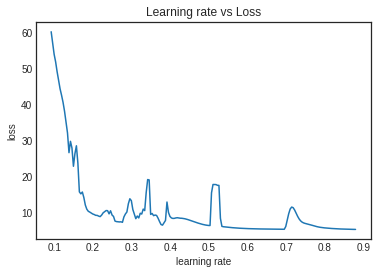

In [0]:
lr_finder.plot_schedule(clip_beginning=25, clip_endding=500)


Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 3456        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
__________________

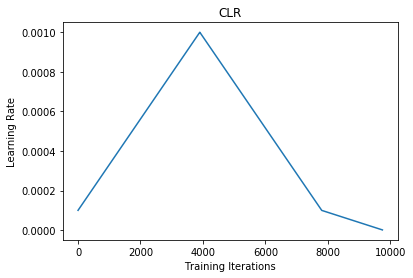

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64))


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_1_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 25
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.2, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
op = RMSprop(lr= 0.0001, epsilon=1e-08)
print(model.summary())
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
--->params {'epochs': 25, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/25
781/781 [==============================] - 463s 592ms/step - loss: 3.0615 - acc: 0.3445 - val_loss: 2.7818 - val_acc: 0.4083
 - lr: 0.00019 

Epoch 00001: val_acc improved from -inf to 0.40825, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_2_0002.hdf5
Epoch 2/25
781/781 [==============================] - 456s 584ms/step - loss: 3.0606 - acc: 0.3419 - val_loss: 2.7929 - val_acc: 0.4011
 - lr: 0.00028 

Epoch 00002: val_acc did not improve from 0.40825
Epoch 3/25
781/781 [==============================] - 456s 583ms/step - loss: 3.0724 - acc: 0.3360 - val_loss: 2.8310 - val_acc: 0.3903
 - lr: 0.00037 

Epoch 00003: val_acc did not improve from 0.40825
Epoch 4/25
781/781 [==============================] - 455s 582ms/step - loss: 3.0960 - acc: 

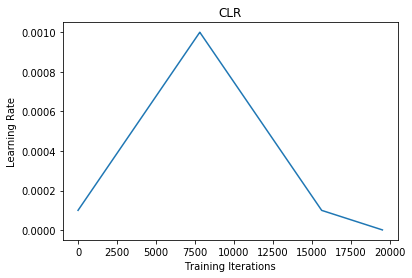

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True, random_crop_size=48)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_2_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 25
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.2, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_1_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
--->params {'epochs': 25, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/25
781/781 [==============================] - 472s 604ms/step - loss: 2.7115 - acc: 0.4575 - val_loss: 2.5415 - val_acc: 0.5161
 - lr: 0.00019 

Epoch 00001: val_acc improved from -inf to 0.51613, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_3_0002.hdf5
Epoch 2/25
781/781 [==============================] - 465s 595ms/step - loss: 2.7445 - acc: 0.4506 - val_loss: 2.5424 - val_acc: 0.5129
 - lr: 0.00028 

Epoch 00002: val_acc did not improve from 0.51613
Epoch 3/25
781/781 [==============================] - 464s 594ms/step - loss: 2.7812 - acc: 0.4439 - val_loss: 2.6142 - val_acc: 0.4968
 - lr: 0.00037 

Epoch 00003: val_acc did not improve from 0.51613
Epoch 4/25
781/781 [==============================] - 464s 594ms/step - loss: 2.8121 - acc: 

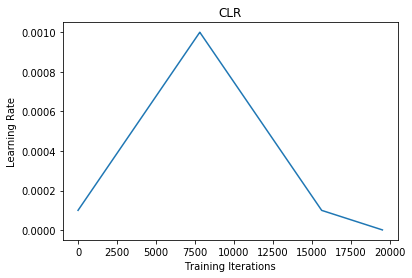

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True, random_crop_size=48)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_3_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 25
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.2, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_2_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
--->params {'epochs': 30, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/30
781/781 [==============================] - 402s 515ms/step - loss: 3.5051 - acc: 0.3598 - val_loss: 2.7589 - val_acc: 0.5438
 - lr: 0.00018 

Epoch 00001: val_acc improved from -inf to 0.54377, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_4_0002.hdf5
Epoch 2/30
781/781 [==============================] - 385s 493ms/step - loss: 3.4924 - acc: 0.3603 - val_loss: 2.7955 - val_acc: 0.5378
 - lr: 0.00026 

Epoch 00002: val_acc did not improve from 0.54377
Epoch 3/30
781/781 [==============================] - 382s 490ms/step - loss: 3.5279 - acc: 0.3550 - val_loss: 2.8761 - val_acc: 0.5189
 - lr: 0.00034 

Epoch 00003: val

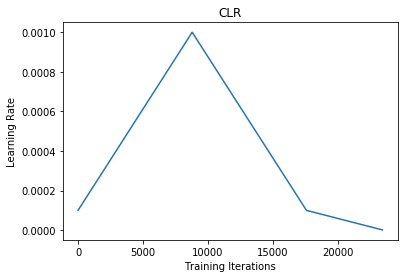

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True, random_crop_size=32)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_4_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 30
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.25, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_3_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
--->params {'epochs': 30, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/30
781/781 [==============================] - 467s 597ms/step - loss: 3.3799 - acc: 0.5255 - val_loss: 3.2855 - val_acc: 0.5602
 - lr: 0.00019 

Epoch 00001: val_acc improved from -inf to 0.56020, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_5_0002.hdf5
Epoch 2/30
781/781 [==============================] - 460s 589ms/step - loss: 3.3760 - acc: 0.5221 - val_loss: 3.3185 - val_acc: 0.5493
 - lr: 0.00027 

Epoch 00002: val_acc did not improve from 0.56020
Epoch 3/30
781/781 [==============================] - 458s 587ms/step - loss: 3.3878 - acc: 0.5179 - val_loss: 3.3840 - val_acc: 0.5283
 - lr: 0.00036 

Epoch 00003: val_acc did not improve from 0.56020
Epoch 4/30
781/781 [==============================] - 458s 587ms/step - loss: 3.4023 - acc: 

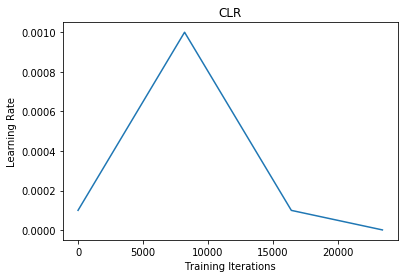

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True, random_crop_size=48)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_5_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 30
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.3, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_4_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
--->params {'epochs': 30, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/30
781/781 [==============================] - 479s 614ms/step - loss: 3.4432 - acc: 0.5770 - val_loss: 3.5801 - val_acc: 0.5661
 - lr: 0.00020 

Epoch 00001: val_acc improved from -inf to 0.56611, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_6_0002.hdf5
Epoch 2/30
781/781 [==============================] - 466s 596ms/step - loss: 3.4782 - acc: 0.5692 - val_loss: 3.5947 - val_acc: 0.5624
 - lr: 0.00030 

Epoch 00002: val_acc did not improve from 0.56611
Epoch 3/30
781/781 [==============================] - 465s 595ms/step - loss: 3.5145 - acc: 0.5620 - val_loss: 3.6724 - val_acc: 0.5425
 - lr: 0.00040 

Epoch 00003: val

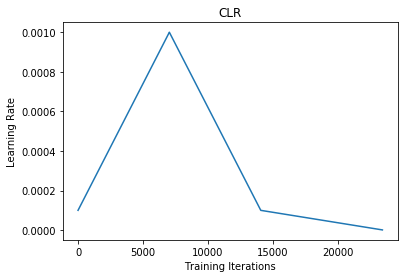

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True, random_crop_size=48)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_6_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 30
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.4, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_5_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
--->params {'epochs': 30, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/30
781/781 [==============================] - 470s 602ms/step - loss: 3.6791 - acc: 0.6015 - val_loss: 3.8449 - val_acc: 0.5781
 - lr: 0.00019 

Epoch 00001: val_acc improved from -inf to 0.57812, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_7_0002.hdf5
Epoch 2/30
781/781 [==============================] - 463s 593ms/step - loss: 3.7148 - acc: 0.5926 - val_loss: 3.8818 - val_acc: 0.5743
 - lr: 0.00027 

Epoch 00002: val_acc did not improve from 0.57812
Epoch 3/30
781/781 [==============================] - 462s 592ms/step - loss: 3.7436 - acc: 0.5876 - val_loss: 3.9083 - val_acc: 0.5731
 - lr: 0.00036 

Epoch 00003: val_acc did not improve from 0.57812
Epoch 4/30
781/781 [==============================] - 463s 593ms/step - loss: 3.7926 - acc: 

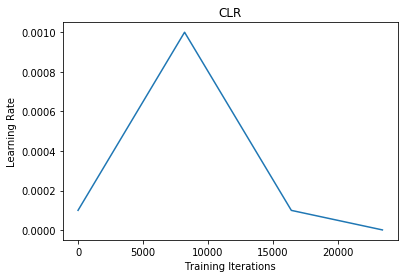

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True, random_crop_size=48)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_7_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 30
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.3, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_6_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
--->params {'epochs': 20, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/20
781/781 [==============================] - 796s 1s/step - loss: 4.0149 - acc: 0.6503 - val_loss: 4.2367 - val_acc: 0.5831
 - lr: 0.00023 

Epoch 00001: val_acc improved from -inf to 0.58313, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_8_0002.hdf5
Epoch 2/20
781/781 [==============================] - 786s 1s/step - loss: 4.0397 - acc: 0.6415 - val_loss: 4.3363 - val_acc: 0.5595
 - lr: 0.00036 

Epoch 00002: val_acc did not improve from 0.58313
Epoch 3/20
781/781 [==============================] - 785s 1s/step - loss: 4.0723 - acc: 0.6314 - val_loss: 4.3163 - val_acc: 0.5600
 - lr: 0.00049 

Epoch 00003: val_acc did 

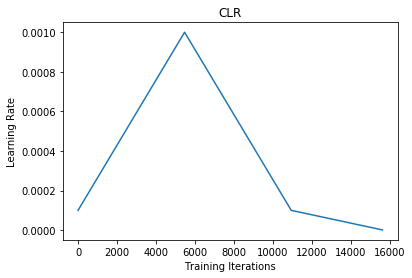

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=False)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_8_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001
# MAX_LR = 0.01

NUM_EPOCHS = 20
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.3, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_7_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
--->params {'epochs': 20, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/20
781/781 [==============================] - 775s 992ms/step - loss: 4.0614 - acc: 0.6724 - val_loss: 4.3391 - val_acc: 0.5928
 - lr: 0.00011 

Epoch 00001: val_acc improved from -inf to 0.59285, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_9_0002.hdf5
Epoch 2/20
781/781 [==============================] - 769s 985ms/step - loss: 4.0779 - acc: 0.6660 - val_loss: 4.3443 - val_acc: 0.5931
 - lr: 0.00016 

Epoch 00002: val_acc improved from 0.59285 to 0.59309, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_9_0002.hdf5
Epoch 3/20
781/781 [==============================] - 769s 985ms/step - loss: 4.0899 - acc: 0.6628 - val_loss: 4.3633 - val_acc: 0.5908
 - lr: 0.00022 

Epoch 00003: val_acc did not improve from 0.59309
Epoch 4/2

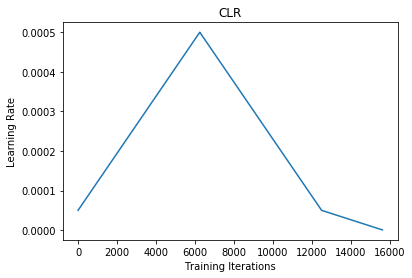

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=False)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_9_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 20
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.2, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_8_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=False)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_10_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
# MAX_LR = 0.001*0.75
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 30
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.3, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_9_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
--->params {'epochs': 30, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/30
781/781 [==============================] - 772s 989ms/step - loss: 4.0682 - acc: 0.6907 - val_loss: 4.4010 - val_acc: 0.5973
 - lr: 0.00009 

Epoch 00001: val_acc improved from -inf to 0.59726, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_10_0002.hdf5
Epoch 2/30
781/781 [==============================] - 768s 983ms/step - loss: 4.0777 - acc: 0.6880 - val_loss: 4.4103 - val_acc: 0.5965
 - lr: 0.00014 

Epoch 00002: val_acc did not improve from 0.59726
Epoch 3/30
781/781 [==============================] - 769s 984ms/step - loss: 4.0850 - acc: 0.6836 - val_loss: 4.4308 - val_acc: 0.5923
 - lr: 0.00018 

Epoch 00003: val_acc did not improve from 0.59726
Epoch 4/30
781/781 [==============================] - 768s 984ms/step - 

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
--->params {'epochs': 20, 'steps': 781, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/20
781/781 [==============================] - 770s 986ms/step - loss: 4.1222 - acc: 0.7101 - val_loss: 4.5519 - val_acc: 0.5922
 - lr: 0.00020 

Epoch 00001: val_acc improved from -inf to 0.59225, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_11_0002.hdf5
Epoch 2/20
781/781 [==============================] - 759s 972ms/step - loss: 4.1684 - acc: 0.6945 - val_loss: 4.6768 - val_acc: 0.5682
 - lr: 0.00035 

Epoch 00002: val_acc did not improve from 0.59225
Epoch 3/20
781/781 [==============================] - 757s 970ms/step - loss: 4.2218 - acc: 0.6782 - val_loss: 4.7510 - val_acc: 0.5489
 - lr: 0.0005

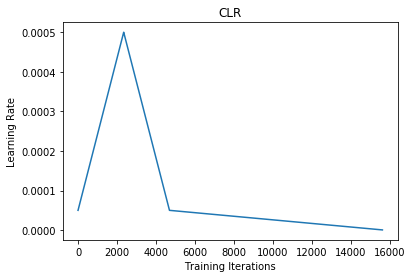

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=False)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_11_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
# MAX_LR = 0.001*0.75
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 20
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.7, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_10_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
--->params {'epochs': 20, 'steps': 390, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
Epoch 1/20
390/390 [==============================] - 265s 679ms/step - loss: 5.3301 - acc: 0.4387 - val_loss: 4.6579 - val_acc: 0.5879
 - lr: 0.00020 

Epoch 00001: val_acc improved from -inf to 0.58794, saving model to /content/gdrive/My Drive/tinyimagenet-model/model_12_0002.hdf5
Epoch 2/20
390/390 [==============================] - 258s 661ms/step - loss: 5.2020 - acc: 0.4449 - val_loss: 4.7032 - val_acc: 0.5709
 - lr: 0.00035 

Epoch 00002: val_acc did not improve from 0.58794
Epoch 3/20
390/390 [==============================] - 256s 658ms/step - loss: 5.2022 - acc: 0.4423 - val_loss: 4.7472 - val_acc: 0.5633
 - lr: 0.00050 

Epoch 00003: val_acc did not improve from 0.58794
Epoch 4/20
390/390 [==============================] - 257s 658ms/step - 

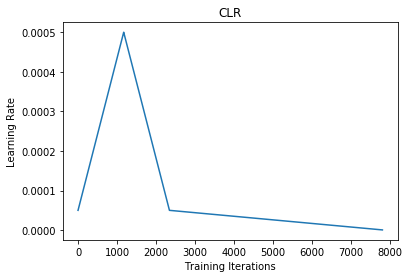

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True, random_crop_size=32)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_12_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
# MAX_LR = 0.001*0.75
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 20
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.7, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
# op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_11_0002.hdf5')
model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
100/100 [==============================] - 29s 285ms/step
[1.9999999999999998, 1.65, 3.1500000000000004, 3.5, 3.1999999999999997, 3.3, 2.45, 3.0500000000000003, 2.15, 2.95, 3.0, 2.8, 2.4000000000000004, 2.5, 2.65, 3.1, 3.75, 2.25, 3.1, 2.5500000000000003, 2.65, 2.05, 2.25, 2.2, 3.8000000000000003, 2.35, 3.1500000000000004, 4.0, 2.8, 4.1, 3.1500000000000004, 2.8, 3.9000000000000004, 3.0, 2.75, 3.1, 2.4000000000000004, 2.6999999999999997, 2.45, 3.75, 3.75, 3.1999999999999997, 3.5, 3.25, 1.4, 1.85, 2.9, 2.85, 3.95, 3.8000000000000003, 2.5999999999999996, 2.85, 2.5500000000000003, 2.9, 2.5, 2.8, 3.0, 2.6999999999999997, 1.9000000000000004, 2.8, 2.5500000000000003, 3.1999999999999997, 4.3, 3.3, 4.6, 3.6, 2.95, 3.45, 2.6999999999999997, 3.25, 3.3, 2.4000000000000004, 3.25, 3.0, 2.85, 3.3, 3.0500000000000003, 4.7, 2.45, 3

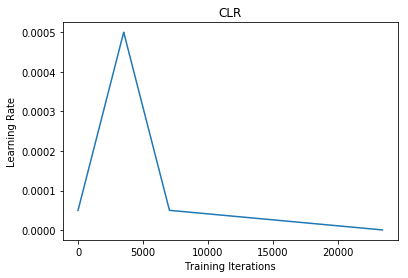

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=False)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_13_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
# MAX_LR = 0.001*0.75
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 30
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.7, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

# model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model = load_model('/content/gdrive/My Drive/tinyimagenet-model/model_12_0002.hdf5')


wts = get_wts(model, factor=5)
print(wts)
loss = weighted_categorical_crossentropy(wts)
model.compile(optimizer=op, loss=loss, metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
100/100 [==============================] - 49s 492ms/step
[1.9000000000000004, 1.7000000000000002, 2.85, 3.4, 3.25, 3.3499999999999996, 2.15, 2.5999999999999996, 1.9000000000000004, 3.0500000000000003, 2.5999999999999996, 2.6999999999999997, 2.4000000000000004, 2.4000000000000004, 2.65, 3.1500000000000004, 3.8000000000000003, 2.15, 3.0500000000000003, 2.5, 2.45, 2.25, 1.9499999999999997, 2.05, 3.55, 1.9499999999999997, 3.1, 3.9000000000000004, 2.65, 3.9000000000000004, 3.4, 2.65, 3.75, 3.3, 2.65, 2.75, 1.9999999999999998, 2.85, 2.65, 3.1, 3.5, 3.3, 3.3, 3.3499999999999996, 1.4499999999999997, 1.85, 2.85, 2.75, 3.6500000000000004, 3.75, 2.45, 2.85, 1.9999999999999998, 2.75, 2.45, 2.75, 2.6999999999999997, 2.6999999999999997, 1.9999999999999998, 3.0, 2.4000000000000004, 3.3499999999999996, 4.1, 3.1, 4.6, 4.15, 3.0500

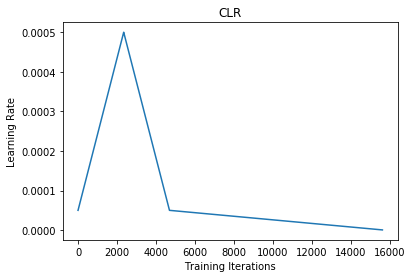

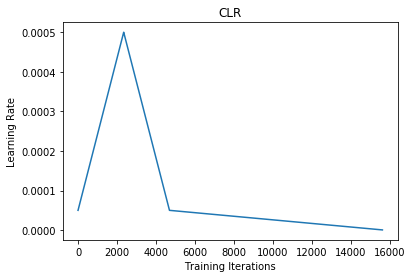

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=False)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_14_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
# MAX_LR = 0.001*0.75
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 20
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.7, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/gdrive/My Drive/tinyimagenet-model/model_13_0002.hdf5')


wts = get_wts(model, factor=5)
print(wts)
loss = weighted_categorical_crossentropy(wts)
model.compile(optimizer=op, loss=loss, metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
100/100 [==============================] - 30s 296ms/step
[1.85, 1.7000000000000002, 2.9, 3.4, 3.4, 3.6500000000000004, 2.3, 2.5999999999999996, 1.75, 2.65, 2.6999999999999997, 2.75, 2.3, 2.45, 2.5, 3.1999999999999997, 3.8000000000000003, 2.15, 3.1, 2.45, 2.35, 2.15, 1.9000000000000004, 1.9999999999999998, 3.55, 1.85, 2.9, 3.7, 2.85, 3.8000000000000003, 3.3499999999999996, 2.65, 3.8000000000000003, 3.25, 2.65, 2.5999999999999996, 1.9999999999999998, 2.85, 2.4000000000000004, 3.0500000000000003, 3.45, 3.25, 3.3499999999999996, 3.1500000000000004, 1.4499999999999997, 1.8000000000000003, 3.0, 2.75, 3.75, 3.8500000000000005, 2.5, 2.9, 2.0999999999999996, 2.85, 2.4000000000000004, 2.75, 2.65, 2.9, 2.15, 2.95, 2.4000000000000004, 3.1, 4.15, 3.45, 4.5, 4.15, 2.9, 3.6, 2.35, 3.1500000000000004, 3.1, 2.5999999999999996, 3.1

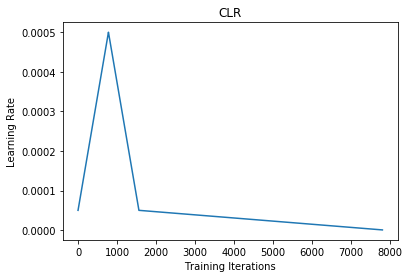

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=True)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_15_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
# MAX_LR = 0.001*0.75
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 20
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.8, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/gdrive/My Drive/tinyimagenet-model/model_14_0002.hdf5')


wts = get_wts(model, factor=5)
print(wts)
loss = weighted_categorical_crossentropy(wts)
model.compile(optimizer=op, loss=loss, metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
100/100 [==============================] - 25s 250ms/step
[1.85, 1.65, 3.3499999999999996, 3.75, 3.1999999999999997, 3.25, 2.2, 3.1, 1.9999999999999998, 2.85, 2.85, 2.75, 2.45, 2.35, 2.5500000000000003, 3.1999999999999997, 3.9000000000000004, 2.25, 3.1, 2.5, 2.3, 2.05, 2.15, 2.0999999999999996, 3.7, 2.2, 3.1500000000000004, 4.0, 2.5999999999999996, 4.05, 3.0500000000000003, 2.75, 3.8500000000000005, 3.25, 2.65, 2.75, 2.2, 3.0500000000000003, 2.35, 3.7, 3.5, 3.1999999999999997, 3.4, 3.3499999999999996, 1.4, 1.8000000000000003, 3.0500000000000003, 2.75, 4.05, 3.8500000000000005, 2.4000000000000004, 2.95, 2.3, 2.95, 2.3, 2.75, 2.9, 2.85, 1.9999999999999998, 2.75, 2.3, 3.0, 4.3, 3.3, 4.6, 3.8000000000000003, 2.6999999999999997, 3.6, 2.65, 3.0500000000000003, 3.1, 2.5, 3.5, 3.1, 2.65, 3.25, 3.0500000000000003, 4.3, 2.25

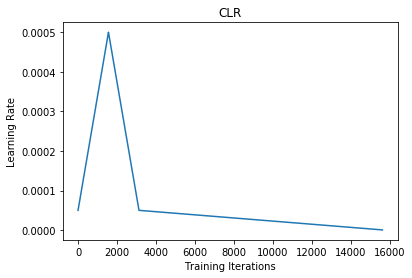

In [0]:
K.clear_session()

from keras.optimizers import RMSprop

# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, no_aug=False, img_size_train=(64,64), img_size_val=(64,64), use_random_crop=False)


# Training utils
base_checkpoint_path='/content/gdrive/My Drive/tinyimagenet-model'
filepath = base_checkpoint_path + "/model_16_0002.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


loss = 'categorical_crossentropy'
# MAX_LR = 0.0002
# MAX_LR = 0.001*0.75
MAX_LR = 0.001/2
# MAX_LR = 0.01

NUM_EPOCHS = 20
clr_triangular = OneCycleLR(max_lr=MAX_LR,
                            batch_size=BATCH_SIZE_TRAIN,
                            samples=NUM_TRAIN_IMAGES,
                            end_percentage=0.8, 
                            scale_percentage=0.1,
                            maximum_momentum=None,
                            minimum_momentum=None
                           )

model = ResnetBuilder.build_resnet_50((NUM_CHANNELS, None, None), NUM_CLASSES, weight_decay=1e-6)
# op = SGD(0.1)
# op = Adam()
op = RMSprop(lr= 0.0001, epsilon=1e-08)
# print(model.summary())
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/gdrive/My Drive/tinyimagenet-model/model_15_0002.hdf5')


wts = get_wts(model, factor=5)
print(wts)
loss = weighted_categorical_crossentropy(wts)
model.compile(optimizer=op, loss=loss, metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    epochs=NUM_EPOCHS, 
                    callbacks=[clr_triangular, model_checkpoint],
                    verbose=1,
                   )


print("LR Range : ", min(clr_triangular.history['lr']), max(clr_triangular.history['lr']))


plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(clr_triangular.history['lr'])
plt.show()